<a href="https://colab.research.google.com/github/realfolkcode/GraphRegression/blob/main/hyperpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import scipy
from scipy.sparse.linalg import cg
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!pip install pickle5

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [3]:
import pickle5 as pickle

In [4]:
!git clone https://github.com/realfolkcode/GraphRegression.git

Cloning into 'GraphRegression'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [5]:
from GraphRegression.utils import set_random_seeds
from GraphRegression.hypergraph import hyper_propagation

# Prepare Data

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
#graphs_dir = '/gdrive/MyDrive/research/67data'
graphs_dir = '/gdrive/MyDrive/research/processed_data'

In [104]:
X = []
y = []

idx = 0
idx_train = []
idx_val = []
idx_test = []

In [105]:
#file_name = os.path.join(graphs_dir + '/63k_train.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_train.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    features = np.hstack((mol[2].sum(axis=0), mol[4]))
    X.append(features)
    y.append(target)
    idx_train.append(idx)
    idx += 1

3390it [00:00, 52876.85it/s]


In [106]:
#file_name = os.path.join(graphs_dir + '/63k_val.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_val.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    features = np.hstack((mol[2].sum(axis=0), mol[4]))
    X.append(features)
    y.append(target)
    idx_val.append(idx)
    idx += 1

377it [00:00, 36119.80it/s]


In [107]:
#file_name = os.path.join(graphs_dir + '/63k_test.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_test.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    features = np.hstack((mol[2].sum(axis=0), mol[4]))
    X.append(features)
    y.append(target)
    idx_test.append(idx)
    idx += 1

290it [00:00, 51087.75it/s]


In [108]:
X = np.array(X)
#X = preprocessing.normalize(X, norm='l1')
scaler = preprocessing.StandardScaler()
scaler.fit(X[idx_train])
X = scaler.transform(X)
y = np.array(y).reshape(-1, 1)

In [109]:
print('Train size:', len(idx_train))
print('Val size:', len(idx_val))
print('Test size:', len(idx_test))

Train size: 3390
Val size: 377
Test size: 290


In [111]:
idx_train_val = np.hstack((idx_train, idx_val))

# Baselines

## Linear Regression

In [112]:
lr = Ridge(alpha=0.01, random_state=42)
lr.fit(X[idx_train], y[idx_train])

Ridge(alpha=0.01, random_state=42)

In [113]:
pred_train = lr.predict(X[idx_train])
pred_val = lr.predict(X[idx_val])
pred_test = lr.predict(X[idx_test])

In [114]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [115]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1.5255281521379414
Val RMSE: 1.5088171577985405
Test RMSE: 1.6315254683315492


In [116]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


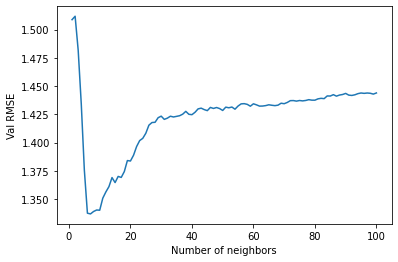

In [117]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [118]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 7


In [119]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [120]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [121]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.3368075503599655
Test RMSE: 1.4902446725457785


## MLP

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 0

In [123]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_in, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x
    
    def get_emb(self, x):
        x = self.features(x)
        return x

In [124]:
def epoch_train(model, loader, criterion, opt):
    train_loss = 0
    model.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(target)
    train_loss /= len(loader.dataset)
    return train_loss

In [125]:
def epoch_val(model, loader, criterion):
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() * len(target)
    val_loss /= len(loader.dataset)
    return val_loss

In [150]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(72).to(device)

In [151]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)

In [152]:
batch_size = 128

train_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_train]), torch.Tensor(y[idx_train])), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_val]), torch.Tensor(y[idx_val])), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_test]), torch.Tensor(y[idx_test])), batch_size=batch_size, shuffle=False)

In [153]:
num_epochs = 53

train_loss = []
val_loss = []
best_epoch = 0
best_loss = 1e9

for i in tqdm(range(num_epochs)):
    loss = np.sqrt(epoch_train(mlp, train_loader, criterion, opt))
    train_loss.append(loss)

    loss = np.sqrt(epoch_val(mlp, val_loader, criterion))
    val_loss.append(loss)
    if loss < best_loss:
        best_epoch = i
        best_loss = loss
    
    scheduler.step()
    
    print('---------------------------------------------------------')
    print(f'Epoch: {i}, Train RMSE: {train_loss[-1]}, Val RMSE: {val_loss[-1]}, Best RMSE: {best_loss}')

  4%|▍         | 2/53 [00:00<00:03, 12.94it/s]

---------------------------------------------------------
Epoch: 0, Train RMSE: 3.399602320930779, Val RMSE: 2.2894984414928974, Best RMSE: 2.2894984414928974
---------------------------------------------------------
Epoch: 1, Train RMSE: 1.9178912387833076, Val RMSE: 1.7626470197224722, Best RMSE: 1.7626470197224722
---------------------------------------------------------
Epoch: 2, Train RMSE: 1.7229497818878758, Val RMSE: 1.6193034380967788, Best RMSE: 1.6193034380967788


 11%|█▏        | 6/53 [00:00<00:03, 12.68it/s]

---------------------------------------------------------
Epoch: 3, Train RMSE: 1.6262498967462244, Val RMSE: 1.688861662009478, Best RMSE: 1.6193034380967788
---------------------------------------------------------
Epoch: 4, Train RMSE: 1.6700625172664094, Val RMSE: 1.5451821172930604, Best RMSE: 1.5451821172930604
---------------------------------------------------------
Epoch: 5, Train RMSE: 1.5636201029593582, Val RMSE: 1.5458763496051309, Best RMSE: 1.5451821172930604


 15%|█▌        | 8/53 [00:00<00:03, 12.28it/s]

---------------------------------------------------------
Epoch: 6, Train RMSE: 1.5436455961785074, Val RMSE: 1.5737545637367314, Best RMSE: 1.5451821172930604
---------------------------------------------------------
Epoch: 7, Train RMSE: 1.570939786852302, Val RMSE: 1.5993452711756548, Best RMSE: 1.5451821172930604
---------------------------------------------------------
Epoch: 8, Train RMSE: 1.5397735847591951, Val RMSE: 1.479674836183899, Best RMSE: 1.479674836183899


 19%|█▉        | 10/53 [00:00<00:04,  9.80it/s]

---------------------------------------------------------
Epoch: 9, Train RMSE: 1.4957919048232222, Val RMSE: 1.5138020554527798, Best RMSE: 1.479674836183899
---------------------------------------------------------
Epoch: 10, Train RMSE: 1.4743081690259332, Val RMSE: 1.4892859428141976, Best RMSE: 1.479674836183899


 25%|██▍       | 13/53 [00:01<00:04,  8.03it/s]

---------------------------------------------------------
Epoch: 11, Train RMSE: 1.47361276624067, Val RMSE: 1.4782035640026268, Best RMSE: 1.4782035640026268
---------------------------------------------------------
Epoch: 12, Train RMSE: 1.5219939280631005, Val RMSE: 1.490085749568578, Best RMSE: 1.4782035640026268
---------------------------------------------------------
Epoch: 13, Train RMSE: 1.4806465156391349, Val RMSE: 1.4448539794720057, Best RMSE: 1.4448539794720057


 34%|███▍      | 18/53 [00:01<00:02, 12.94it/s]

---------------------------------------------------------
Epoch: 14, Train RMSE: 1.4533025114981473, Val RMSE: 1.461431137417128, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 15, Train RMSE: 1.435237624382775, Val RMSE: 1.511619461856149, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 16, Train RMSE: 1.448656718326999, Val RMSE: 1.4570336834439221, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 17, Train RMSE: 1.42845825340646, Val RMSE: 1.4552706866352354, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 18, Train RMSE: 1.422438181832384, Val RMSE: 1.505728470573485, Best RMSE: 1.4448539794720057


 45%|████▌     | 24/53 [00:01<00:01, 17.20it/s]

---------------------------------------------------------
Epoch: 19, Train RMSE: 1.4486048643590121, Val RMSE: 1.4900259128771063, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 20, Train RMSE: 1.411834420758284, Val RMSE: 1.497979477908772, Best RMSE: 1.4448539794720057
---------------------------------------------------------
Epoch: 21, Train RMSE: 1.4258990623944392, Val RMSE: 1.4359687658394429, Best RMSE: 1.4359687658394429
---------------------------------------------------------
Epoch: 22, Train RMSE: 1.423103306470883, Val RMSE: 1.4045605749949384, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 23, Train RMSE: 1.428006413928054, Val RMSE: 1.471071592027963, Best RMSE: 1.4045605749949384


 51%|█████     | 27/53 [00:02<00:01, 18.25it/s]

---------------------------------------------------------
Epoch: 24, Train RMSE: 1.458642563657778, Val RMSE: 1.5834450461098444, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 25, Train RMSE: 1.4709381157393873, Val RMSE: 1.4290902266848051, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 26, Train RMSE: 1.4442873462799497, Val RMSE: 1.4704659855218072, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 27, Train RMSE: 1.4194322352943713, Val RMSE: 1.4286248154564567, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 28, Train RMSE: 1.4090822407402197, Val RMSE: 1.4223740921247618, Best RMSE: 1.4045605749949384


 62%|██████▏   | 33/53 [00:02<00:01, 19.92it/s]

---------------------------------------------------------
Epoch: 29, Train RMSE: 1.4096853982422755, Val RMSE: 1.4556998395129743, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 30, Train RMSE: 1.3833188100838714, Val RMSE: 1.435320285617206, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 31, Train RMSE: 1.3761977622163986, Val RMSE: 1.4134587290955223, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 32, Train RMSE: 1.3965910973963664, Val RMSE: 1.4346774291880284, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 33, Train RMSE: 1.392814099353761, Val RMSE: 1.4878199906863205, Best RMSE: 1.4045605749949384


 74%|███████▎  | 39/53 [00:02<00:00, 20.51it/s]

---------------------------------------------------------
Epoch: 34, Train RMSE: 1.4053693510872887, Val RMSE: 1.4849171672062706, Best RMSE: 1.4045605749949384
---------------------------------------------------------
Epoch: 35, Train RMSE: 1.4330627794462745, Val RMSE: 1.3851290511841792, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 36, Train RMSE: 1.3865342205509972, Val RMSE: 1.387125457284529, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 37, Train RMSE: 1.36848051412068, Val RMSE: 1.3973452760552127, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 38, Train RMSE: 1.3636104256199753, Val RMSE: 1.4191205189923246, Best RMSE: 1.3851290511841792


 79%|███████▉  | 42/53 [00:02<00:00, 20.75it/s]

---------------------------------------------------------
Epoch: 39, Train RMSE: 1.3507919317843653, Val RMSE: 1.4152788216506595, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 40, Train RMSE: 1.4108911301887928, Val RMSE: 1.4766131750223357, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 41, Train RMSE: 1.3561005865946412, Val RMSE: 1.4026970145165565, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 42, Train RMSE: 1.3446152085398904, Val RMSE: 1.4056027213142037, Best RMSE: 1.3851290511841792
---------------------------------------------------------
Epoch: 43, Train RMSE: 1.3665689263989451, Val RMSE: 1.3512314130223193, Best RMSE: 1.3512314130223193


 91%|█████████ | 48/53 [00:03<00:00, 20.32it/s]

---------------------------------------------------------
Epoch: 44, Train RMSE: 1.3618705898627887, Val RMSE: 1.4559261360684417, Best RMSE: 1.3512314130223193
---------------------------------------------------------
Epoch: 45, Train RMSE: 1.3721460150468694, Val RMSE: 1.494788680336878, Best RMSE: 1.3512314130223193
---------------------------------------------------------
Epoch: 46, Train RMSE: 1.3624887357927893, Val RMSE: 1.4271745735993673, Best RMSE: 1.3512314130223193
---------------------------------------------------------
Epoch: 47, Train RMSE: 1.3471924465161085, Val RMSE: 1.3909959068508866, Best RMSE: 1.3512314130223193


100%|██████████| 53/53 [00:03<00:00, 16.18it/s]

---------------------------------------------------------
Epoch: 48, Train RMSE: 1.3471818842873329, Val RMSE: 1.3546366623903683, Best RMSE: 1.3512314130223193
---------------------------------------------------------
Epoch: 49, Train RMSE: 1.3525591333972158, Val RMSE: 1.3576313068124635, Best RMSE: 1.3512314130223193
---------------------------------------------------------
Epoch: 50, Train RMSE: 1.3090287975889756, Val RMSE: 1.3357000097697738, Best RMSE: 1.3357000097697738
---------------------------------------------------------
Epoch: 51, Train RMSE: 1.2871615198637667, Val RMSE: 1.3158226973168097, Best RMSE: 1.3158226973168097
---------------------------------------------------------
Epoch: 52, Train RMSE: 1.2722005634208486, Val RMSE: 1.36966266293868, Best RMSE: 1.3158226973168097


In [154]:
pred_train = mlp(torch.Tensor(X[idx_train]).to(device)).detach().cpu().numpy()
pred_val = mlp(torch.Tensor(X[idx_val]).to(device)).detach().cpu().numpy()
pred_test = mlp(torch.Tensor(X[idx_test]).to(device)).detach().cpu().numpy()

In [155]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [156]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1.2556439135045767
Val RMSE: 1.3696626783846924
Test RMSE: 1.5178031039992823


In [157]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


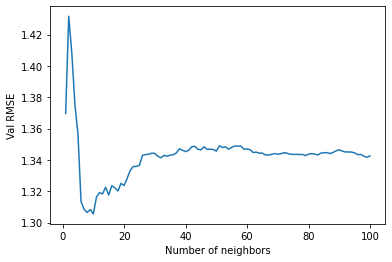

In [158]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [159]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 10


In [160]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [161]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [162]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.3055228849813998
Test RMSE: 1.4824734620013196


## CatBoost

In [163]:
!pip install catboost

In [164]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [165]:
cb = CatBoostRegressor(iterations=1000,
                       random_state=42,
                       l2_leaf_reg=50,
                       learning_rate=0.3,
                       use_best_model=True)

In [166]:
cb.fit(X[idx_train], y[idx_train],
       eval_set=(X[idx_val], y[idx_val]))

0:	learn: 1.8434877	test: 1.8007189	best: 1.8007189 (0)	total: 15.2ms	remaining: 15.2s
1:	learn: 1.7432884	test: 1.7095926	best: 1.7095926 (1)	total: 24.2ms	remaining: 12.1s
2:	learn: 1.6646884	test: 1.6376026	best: 1.6376026 (2)	total: 33ms	remaining: 11s
3:	learn: 1.6134709	test: 1.5903172	best: 1.5903172 (3)	total: 41.3ms	remaining: 10.3s
4:	learn: 1.5752437	test: 1.5524864	best: 1.5524864 (4)	total: 49.6ms	remaining: 9.87s
5:	learn: 1.5473020	test: 1.5324089	best: 1.5324089 (5)	total: 57.8ms	remaining: 9.58s
6:	learn: 1.5266596	test: 1.5188108	best: 1.5188108 (6)	total: 66.2ms	remaining: 9.39s
7:	learn: 1.5088212	test: 1.5032555	best: 1.5032555 (7)	total: 74.3ms	remaining: 9.21s
8:	learn: 1.4931945	test: 1.4850648	best: 1.4850648 (8)	total: 82.6ms	remaining: 9.09s
9:	learn: 1.4745577	test: 1.4697968	best: 1.4697968 (9)	total: 91.1ms	remaining: 9.02s
10:	learn: 1.4663273	test: 1.4638915	best: 1.4638915 (10)	total: 99.1ms	remaining: 8.91s
11:	learn: 1.4613598	test: 1.4632248	best: 1.

In [167]:
pred_train = cb.predict(X[idx_train]).reshape(-1, 1)
pred_val = cb.predict(X[idx_val]).reshape(-1, 1)
pred_test = cb.predict(X[idx_test]).reshape(-1, 1)

In [168]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [169]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 0.6307302930743409
Val RMSE: 1.2839073415630915
Test RMSE: 1.3317345352973968


In [170]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


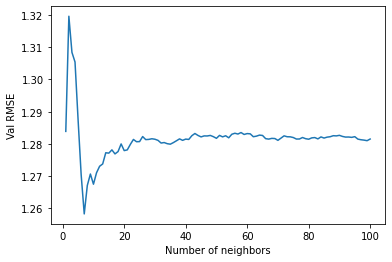

In [171]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [172]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 7


In [173]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [174]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [175]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.2583176859479297
Test RMSE: 1.330803330267785
